# Lance is pip-installable

- Wheels are available for python 3.8-3.10 on Linux and Mac (arm and intel)
- Windows support is forthcoming

In [1]:
!pip install --quiet pylance

import lance
lance.__version__

'0.2.2'

# Read/write Lance via Apache Arrow

In [2]:
import pandas as pd
import pyarrow as pa

tbl = pa.Table.from_pandas(pd.DataFrame({'a': [1,2,3]}))
lance.write_dataset(tbl, "/tmp/test.lance")

In [3]:
test = lance.dataset("/tmp/test.lance")
test.to_table().to_pandas()

,a
0,1
1,2
2,3


# Easy to convert popular formats to Lance

In [4]:
from fastai.vision.all import untar_data, URLs
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#2) [Path('/home/ubuntu/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/ubuntu/.fastai/data/oxford-iiit-pet/images')]

In [6]:
from lance.data.convert.oxford_pet import OxfordPetConverter
c = OxfordPetConverter(str(path), str(path) + '/')
metadata = c.read_metadata()
print(len(metadata))
metadata.head(5)

7349


,_pk,filename,class,species,breed,split,folder,source,size,segmented,object,external_image
0,0,Abyssinian_100,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 394, 'height': 500, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[151, 71, 335, 267]], 'difficult': [False]}",/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg
1,1,Abyssinian_101,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 450, 'height': 313, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[54, 36, 319, 235]], 'difficult': [False]}",/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg
2,2,Abyssinian_102,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 500, 'height': 465, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[23, 27, 325, 320]], 'difficult': [False]}",/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg
3,3,Abyssinian_103,Abyssinian,Cat,1,train,OXIIIT,"{'database': 'OXFORD-IIIT Pet Dataset', 'annotation': 'OXIIIT', 'image': 'flickr'}","{'width': 500, 'height': 351, 'depth': 3}",True,"{'name': ['cat'], 'pose': ['Frontal'], 'truncated': [False], 'occluded': [False], 'bndbox': [[241, 68, 362, 196]], 'difficult': [False]}",/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg
4,4,Abyssinian_104,Abyssinian,Cat,1,train,NaN,NaN,NaN,<NA>,"{'name': [], 'pose': [], 'truncated': [], 'occluded': [], 'bndbox': [], 'difficult': []}",/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg


# Write in batches to save memory

In [7]:
# I'm bad at naming things
c.make_embedded_dataset(metadata[:1000],
                        output_path="/tmp/pet.lance",
                        mode="create")

for i in range(1, 8):
    start = i * 1000
    end = min(len(metadata), (i+1)*1000)
    c.make_embedded_dataset(metadata[start:end],
                            output_path="/tmp/pet.lance",
                            mode="append")

## Lance datasets are easy to query

In [8]:
from lance.util.duckdb_ext import install_duckdb_extension
install_duckdb_extension()
%load_ext sql
%sql duckdb:///:memory: --connection_arguments {"config":{"allow_unsigned_extensions":"true"},"preload_extensions":["lance"]}

{'config': {'allow_unsigned_extensions': 'true'}, 'preload_extensions': ['lance']}


In [10]:
oxford_pet = lance.dataset("/tmp/pet.lance")
assert isinstance(oxford_pet, pa.dataset.Dataset)

In [12]:
%%sql distro <<

SELECT split, class, count(1) as cnt
FROM oxford_pet
GROUP BY 1, 2

Took 0.007290840148925781


,split,class,cnt
0,test,basset_hound,100
1,test,beagle,100
2,test,Bengal,100
3,test,Birman,100
4,test,Bombay,88
...,...,...,...
106,test,leonberger,100
107,test,Maine_Coon,100
108,test,miniature_pinscher,100
109,test,newfoundland,100


In [13]:
%%sql

SELECT split, entropy(cnt), skewness(cnt)
FROM distro
GROUP BY 1

Took 0.0030486583709716797


,split,entropy(cnt),skewness(cnt)
0,test,1.102383,-3.791110
1,train,0.357429,-5.326151
2,val,0.756619,-2.618938


In [14]:
df = distro.pivot(values='cnt', index='class', columns='split').sort_values(by='train', ascending=False)

<AxesSubplot: xlabel='class'>

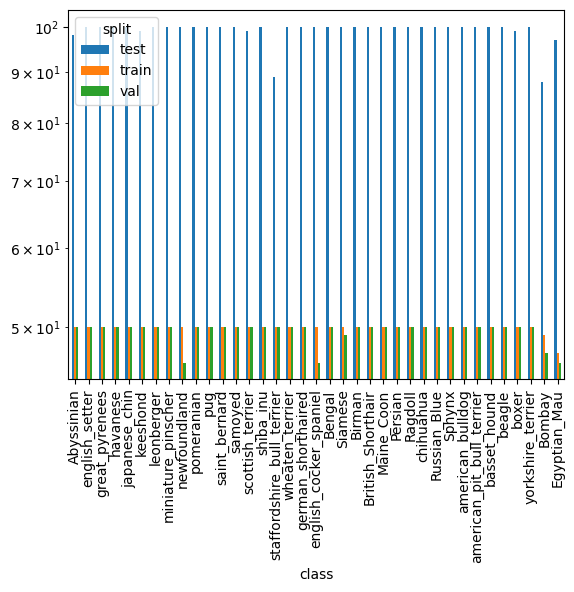

In [16]:
df.plot.bar(logy=True)

# Lance supports remote blob stores too

In [17]:
pets = lance.dataset("s3://eto-public/datasets/oxford_pet/oxford_pet.lance")

# Drilling-down (experimental)

In [18]:
%%sql --lance

SELECT external_image as _image
FROM pets
WHERE split='train' and class='samoyed'
LIMIT 20

Took 1.7489426136016846


# Run models in SQL! 

- pre-labeling 
- inference
- model eval
- uncertainty sampling
- active learning etc

In [19]:
import torch
from torchvision.models import resnet18, ResNet18_Weights

resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
m = torch.jit.script(resnet)
torch.jit.save(m, '/tmp/model.pth')

In [20]:
%%sql

CALL create_pytorch_model('resnet', '/tmp/model.pth', 'cuda');
SELECT * FROM ml_models();

Took 1.1193568706512451


,name,uri,type,device
0,resnet,/tmp/model.pth,torchscript,cuda


In [22]:
%%sql class_prob <<

SELECT predict('resnet', image) as prob
FROM oxford_pet
WHERE class='samoyed'
LIMIT 100

Took 1.8153023719787598


,prob
0,"[3.884816396748647e-05, 2.2368893041857518e-05, 9.202101500704885e-05, 1.4751317394257057e-05, 7.794502380420454e-06, 1.2650688404391985e-05, 6.27820918452926e-05, 0.00012374906509649009, 0.00023291412799153477, 0.0009026342304423451, 2.638767909957096e-05, 0.0001475257595302537, 7.073329470586032e-05, 6.752804620191455e-05, 0.00011918305972358212, 4.944473039358854e-05, 0.00031135641620494425, 0.0005889010499231517, 0.00017135858070105314, 0.000492246588692069, 0.00019665037689264864, 0.0004143535334151238, 0.0004046402173116803, 0.0004626368172466755, 0.0003032205277122557, 1.91587078006..."
1,"[0.001062052440829575, 8.164277824107558e-05, 0.00030080194119364023, 6.597142055397853e-05, 0.0002406607090961188, 8.216615242417902e-05, 0.00020961681730113924, 0.0006136195152066648, 0.0007164766429923475, 0.000635442091152072, 1.258794691239018e-05, 5.32546873728279e-05, 8.68371207616292e-05, 4.628674651030451e-05, 0.00024368918093387038, 4.449152766028419e-05, 3.78007571271155e-05, 0.0005134443053975701, 0.00047085905680432916, 0.00015565742796752602, 2.0462557586142793e-05, 0.00020592597138602287, 0.000192348423297517, 0.0004446692473720759, 0.00020062863768544048, 4.318773062550463e..."
2,"[0.00012389685434754938, 0.0002734442532528192, 0.00027899438282474875, 4.017664468847215e-05, 0.00020777431200258434, 6.333377677947283e-05, 0.00018296646885573864, 0.004759533330798149, 0.003053052118048072, 0.0005729306722059846, 7.736352563370019e-05, 0.0003574929141905159, 0.00023316287843044847, 0.0002807783312164247, 0.0002519225818105042, 0.0002619739098008722, 0.0003672167949844152, 0.0009202365181408823, 0.0007057340117171407, 0.0005386514239944518, 6.956998549867421e-05, 0.00038357157609425485, 0.0003822141152340919, 0.0012667995179072022, 0.00030566545319743454, 7.2233837272506..."
3,"[0.00019978209456894547, 4.3260024540359154e-05, 0.0003106773947365582, 3.8358906749635935e-05, 0.00011575005919439718, 0.000500090594869107, 0.0009697620407678187, 0.0007332274108193815, 0.0015454934909939766, 0.0001335445122094825, 1.6786028936621733e-05, 4.739074211101979e-05, 4.121641904930584e-05, 7.821426697773859e-05, 6.20878636254929e-05, 5.2089071687078103e-05, 4.347450885688886e-05, 0.0002455132780596614, 0.00017587993352208287, 0.00016290701751131564, 6.772258348064497e-05, 2.675070754776243e-05, 0.0001164352725027129, 0.00015092379180714488, 0.00010031310375779867, 4.9584999942..."
4,"[0.0001520993246231228, 5.70026932109613e-05, 0.00025372032541781664, 8.231677929870784e-05, 0.000280387990642339, 4.596774670062587e-05, 0.0001235916861332953, 0.00012559910828713328, 0.0001218796824105084, 0.000143001539981924, 1.1729496691259556e-05, 2.176373527618125e-05, 1.4522847777698189e-05, 4.406562220538035e-05, 3.626998659456149e-05, 2.4064313038252294e-05, 8.579654968343675e-05, 0.0003049121587537229, 6.302803376456723e-05, 0.00011210038792341948, 7.747883500996977e-05, 2.5752615329110995e-05, 4.602297121891752e-05, 4.63875439891126e-05, 4.4743017497239634e-05, 1.56507067003985..."
...,...
95,"[5.440341283247108e-06, 4.092057679372374e-06, 1.124569826060906e-05, 1.1310819445498055e-06, 2.1240939531708136e-06, 7.092005034792237e-06, 1.009064908430446e-05, 2.6251245799358003e-05, 6.475866393884644e-05, 2.378002682235092e-05, 5.405893830356945e-07, 2.3282625534193357e-06, 1.106626655200671e-06, 2.225089019702864e-06, 2.202114728788729e-06, 4.4631323703470116e-07, 4.988426098861964e-06, 1.8699151041801088e-05, 9.227831469615921e-06, 1.2417061952874064e-05, 2.460887571942294e-06, 9.417007277079392e-06, 2.3410235371557064e-05, 5.2163784857839346e-05, 1.2499147487687878e-05, 1.67164989..."
96,"[6.032520832377486e-05, 0.0002026800939347595, 0.00047700718278065324, 9.480654262006283e-05, 7.129462755983695e-05, 0.00023079707170836627, 0.0009370446787215769, 0.0003821534337475896, 0.00046588509576395154, 0.0002524512237869203, 3.5982808185508475e-05, 8.464908023597673e-05, 0.00014193213428370655, 5.40542314411141e-05, 0.00011709686077665538, 9.2105

In [23]:
%%sql

SELECT list_argmax(prob) as predicted_class,
       list_max(prob) as score
FROM class_prob

Took 0.06675267219543457


,predicted_class,score
0,258,0.317622
1,258,0.078113
2,258,0.069442
3,258,0.469027
4,750,0.089489
...,...,...
95,258,0.825028
96,258,0.146342
97,258,0.102551
98,270,0.219501


# Btw, Lance is automatically versioned!

In [24]:
oxford_pet.versions()

[{'version': 1},
 {'version': 2},
 {'version': 3},
 {'version': 4},
 {'version': 5},
 {'version': 6},
 {'version': 7},
 {'version': 8}]

# No need for YAML files or git-like workflows

In [25]:
uri = '/tmp/pet.lance'
v1 = lance.dataset(uri, version=1)
v2 = lance.dataset(uri, version=2)

In [26]:
v1.count_rows()

1000

In [27]:
v2.count_rows()

2000

# Enables comparisons and tracking across versions

In [28]:
%%sql df <<

SELECT 'v1' as version, class, count(1) as cnt FROM v1 GROUP BY 1, 2
UNION
SELECT 'v2' as version, class, count(1) as cnt FROM v2 GROUP BY 1, 2

Took 0.005845308303833008


,version,class,cnt
0,v1,Abyssinian,50
1,v1,american_bulldog,50
2,v1,american_pit_bull_terrier,50
3,v1,basset_hound,50
4,v1,beagle,50
5,v1,Bengal,50
6,v1,Birman,50
7,v1,Bombay,49
8,v1,boxer,50
9,v1,British_Shorthair,50


<AxesSubplot: xlabel='class'>

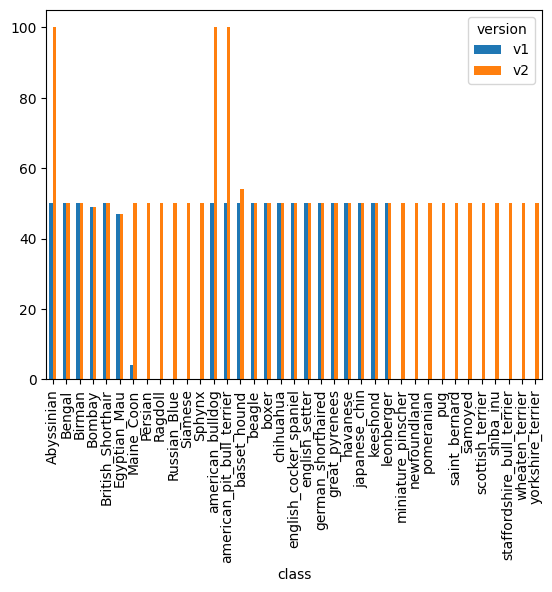

In [29]:
df.pivot(index='class', columns='version', values='cnt').plot.bar()

# Lance's roadmap is even more exciting
- next week: append_column (e.g., add model results, different labeling sources, etc)
- Forthcoming: 
  - updates/deletes
  - richer visualizations for exploration / curation
  - vector indices baked-in